/Users/qahme/Dev/.virtualenvs/stock3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/qahme/Dev/.virtualenvs/stock3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/qahme/Dev/.virtualenvs/stock3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/qahme/Dev/.virtualenvs/stock3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/qahme/Dev/.virtualenvs/stock3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: 
.ix is deprecated. Pleas

<IPython.core.display.Javascript object>


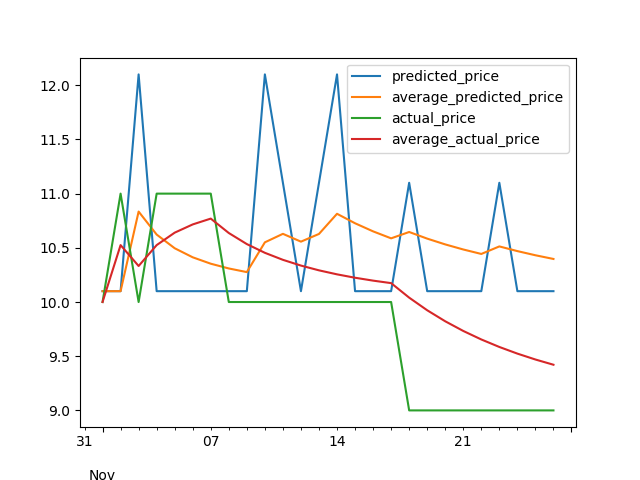

<IPython.core.display.Javascript object>


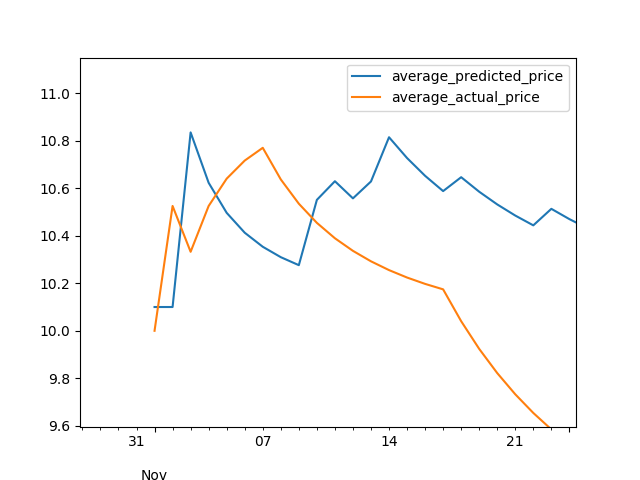

<IPython.core.display.Javascript object>


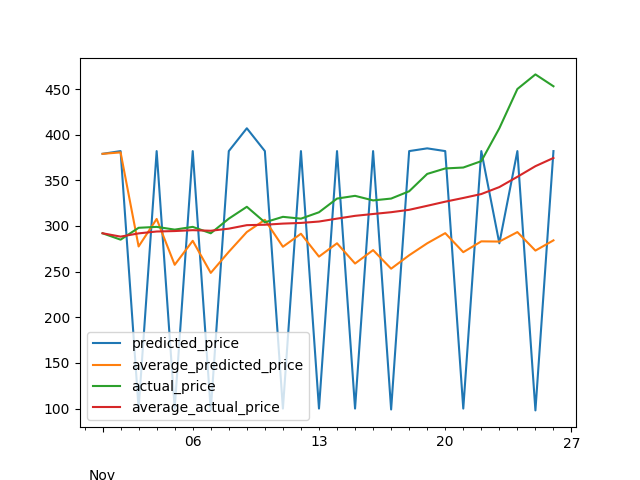

<IPython.core.display.Javascript object>


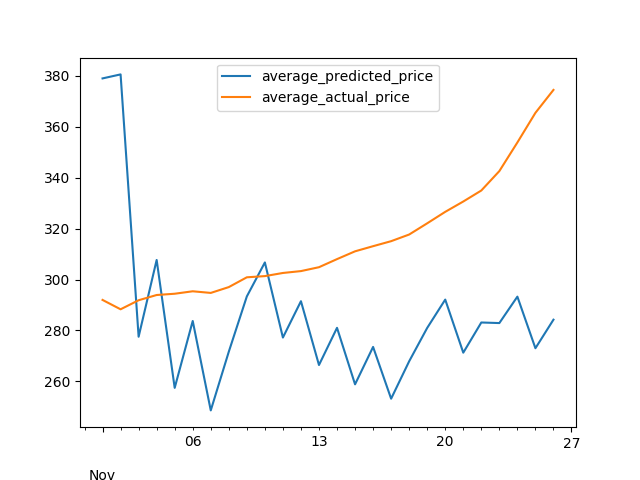

<IPython.core.display.Javascript object>


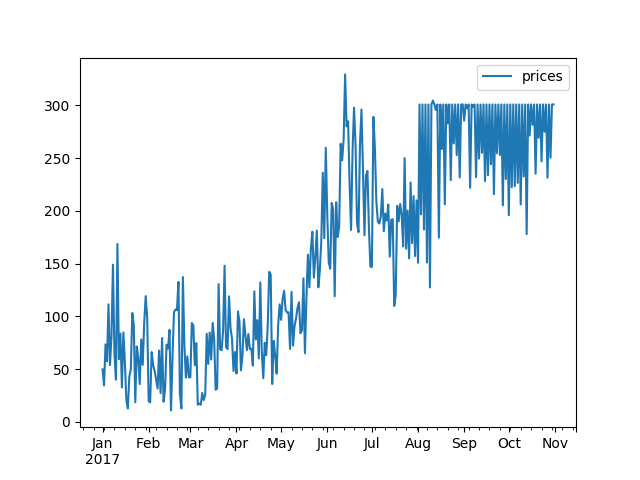

In [32]:
%matplotlib notebook


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import unicodedata
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from utils import offset_value
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from treeinterpreter import treeinterpreter as ti
from os import path
import matplotlib.pyplot as plt

# Reading the saved data pickle file
df_stocks = pd.read_pickle(path.relpath("Data/my_pickled_one_year_filtered_lead_para.pkl"))

df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)
df_stocks = df_stocks[['prices', 'articles']]
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))
df = df_stocks[['prices']].copy()
# Adding new columns to the data frame
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles'])
    ss = sid.polarity_scores(sentence)
    df.set_value(date, 'compound', ss['compound'])
    df.set_value(date, 'neg', ss['neg'])
    df.set_value(date, 'neu', ss['neu'])
    df.set_value(date, 'pos', ss['pos'])

train_start_date = '2016-01-01'
train_end_date = '2017-05-31'
test_start_date = '2017-06-01'
test_end_date = '2017-11-20'

train = df.ix[train_start_date : train_end_date]
test = df.ix[test_start_date:test_end_date]

y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices']) 

##Starts here
years = [2016,2017]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-11-26'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        if(df.loc[date, 'compound'] != ''):
            sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
            sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        if(df.loc[date, 'compound'] != ''):
            sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
            #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
            sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
    mlpc.fit(numpy_df_train, train['prices']) 

    prediction = mlpc.predict(numpy_df_test)
    prediction_list.append(prediction)
    idx = pd.date_range(test_start_date, test_end_date)
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = pd.ewma(predictions_df_list["prices"], span=20, freq="D")
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = pd.ewma(predictions_df_list["actual_value"], span=20, freq="D")
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    fig = predictions_df_list.plot().get_figure()
    fig.savefig("graphs/etherium/MLP_ether "+str(year) +".png")
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    fig = predictions_df_list_average.plot().get_figure()
    fig.savefig("graphs/etherium/MLP_average_ether"+str(year) +".png")
    

mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='tanh', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False)
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False) # span = 20
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 50), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False)
          
# Generating models
rf = RandomForestRegressor(random_state=42)
rf.fit(numpy_df_train, train['prices'])

# checking the performance of training data itself
prediction, bias, contributions = ti.predict(rf, numpy_df_train)
idx = pd.date_range(train_start_date, train_end_date)
predictions_df1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
fig = predictions_df1.plot().get_figure()
fig.savefig(path.relpath("graphs/etherium/MLP_p_ether.png"))

# predictions_df1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices', 'predicted price'])
# fig = train['prices'].plot().get_figure()
# fig.savefig(path.relpath("graphs/etherium/MLP_p2_ether.png"))